# 데이터 불러오기
- 데이터 형태는 
- X = (3950, 20)과 같이 (전체 데이터 개수, voca_size)
- y = (3950,1) 과같이 (전체 데이터 개수, 정수)

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras import regularizers

# 데이터 로드 및 준비
- 이 단계에서는 학습에 필요한 데이터를 로드하고 전처리합니다. 데이터를 불러온 후 각 대화 유형에 따라 레이블을 부여하고, 모델 학습에 필요한 텍스트 데이터를 토큰화합니다.
- 학습 데이터를 CSV 파일에서 로드합니다.
- CLASS_NAMES 리스트는 각 클래스의 이름을 정의하여 레이블과 대화를 매핑합니다.
- corpus 변수에는 텍스트 데이터가, labels 변수에는 해당 텍스트에 대한 클래스 레이블이 저장됩니다.

In [2]:
# 데이터 로드
train_data_path = "./train_general.csv"
train_data = pd.read_csv(train_data_path)

# 클래스 이름
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

# 전체 corpus와 클래스 레이블 준비
corpus = train_data["cleaned_conversation"]
labels = train_data['class']

train_data.head()

,idx,class,conversation,text_length,word_count,cleaned_conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,52,52,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,39,39,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,52,52,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,34,34,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,118,118,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...


# 토큰화 함수 정의
- tokenize 함수는 텍스트 데이터를 토큰화하고 패딩을 적용하여 일정한 길이의 숫자 시퀀스로 변환합니다.
- num_words=10000: 가장 빈도가 높은 10,000개의 단어만 사용하여 토큰화합니다.
- oov_token="unk": 단어 사전에 없는 단어는 'unk'로 처리합니다.
- corpus를 토큰화하여 tensor에 숫자 시퀀스를 저장하고, 학습에 사용할 토큰 사전을 tokenizer에 저장합니다.

In [3]:
# 토큰화 + encoding 진행 
# 변수 = voca_size, 토큰화 방법

def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=10000, 
        filters=' ',
        oov_token="<unk>")
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=100)  
    return tensor, tokenizer

# 토큰화 수행
tensor, tokenizer = tokenize(corpus)

In [4]:
# (데이터 개수, max_length)
tensor.shape

(4976, 100)

# 클래스 가중치 계산
- train_test_split을 사용하여 데이터를 학습, 검증, 테스트 데이터셋으로 나눕니다.
- stratify=labels: 각 클래스의 비율이 일정하도록 분할합니다.
- compute_class_weight를 사용하여 각 클래스에 대한 가중치를 계산합니다.
- class_weights는 학습 중에 클래스 불균형을 보정하기 위해 사용됩니다
- 각 샘플에 대해 해당 클래스에 맞는 가중치를 할당하여 sample_weights에 저장합니다.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(tensor, labels, test_size=0.2, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [6]:
# 클래스 가중치 계산 (클래스 4 포함)
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# 각 샘플에 가중치 할당
sample_weights = np.array([class_weights[y] for y in y_train])

# tf.data.Dataset으로 변환 (sample_weight 포함)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weights))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# 데이터셋을 섞고, 배치 처리
train_dataset = train_dataset.cache().shuffle(10000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(32)

# 모델

# Positional Encoding Layer 정의
- 이 단계에서는 위치 인코딩 레이어를 정의하여, Transformer 모델이 입력된 토큰의 순서를 학습할 수 있도록 합니다.
- 입력된 단어의 위치 정보를 이용해 각 단어의 임베딩 벡터에 위치 정보를 더해줍니다.
- positional_encoding 함수는 위치에 따른 각 토큰의 각도를 계산하여 사인 및 코사인 값을 생성합니다.

In [7]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# Scaled Dot-Product Attention
- scaled_dot_product_attention 함수는 어텐션 메커니즘을 구현하며, 입력된 query, key, value 텐서와 마스크를 이용해 가중합을 계산합니다.
- query와 key의 내적을 구하여 어텐션 스코어를 계산합니다.
- 어텐션 스코어를 소프트맥스 함수로 변환하여 가중치를 계산하고, value에 곱해 최종 출력값을 얻습니다.

In [8]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    if mask is not None:
        logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output

# Multi-Head Attention Layer
- MultiHeadAttention 클래스는 다중 헤드 어텐션 레이어를 정의하여, 입력된 토큰이 다양한 어텐션 스코어를 통해 서로 다른 부분을 집중할 수 있도록 합니다.
- split_heads 메소드:
    - 입력을 여러 개의 헤드로 나누어 병렬 계산이 가능하도록 합니다.
- call 메소드:
    - Query, Key, Value 입력을 받아 여러 헤드에 대해 어텐션을 수행하고, 최종적으로 통합합니다.

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        outputs = self.dense(concat_attention)
        return outputs

In [10]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

# Transformer Encoder Layer
- encoder_layer 함수는 Transformer의 인코더 레이어를 정의합니다. 각 레이어는 다중 헤드 어텐션과 피드포워드 신경망으로 구성됩니다.
- Layer Normalization과 Dropout을 통해 과적합을 방지하고 안정적인 학습이 이루어지도록 합니다.

In [11]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
    outputs = tf.keras.layers.Dense(units=units, activation='relu', kernel_regularizer=regularizers.l2(1e-3))(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [12]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout, name="encoder_layer_{}".format(i))([outputs, padding_mask])
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 전체 Transformer 모델 정의
- transformer 함수는 전체 Transformer 모델을 정의하며, 입력 데이터에 대한 패딩 마스크를 포함하여 인코더의 출력과 최종 출력을 계산합니다.
- encoder 함수는 여러 개의 인코더 레이어를 쌓아 최종 인코더 출력을 생성합니다.
- CLS 토큰과 유사하게 시퀀스의 첫 번째 토큰을 추출하여 최종 분류에 사용됩니다.

In [220]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):    
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    
    # 인코더 출력
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[inputs, enc_padding_mask])
    
    # 첫 번째 토큰을 추출 (CLS 토큰과 유사한 방식)
    cls_token = enc_outputs[:, 0, :]  # 시퀀스의 첫 번째 토큰 선택

    # Dropout 및 Dense 레이어 연결
    cls_token = tf.keras.layers.Dropout(rate=dropout)(cls_token)
    outputs = tf.keras.layers.Dense(units=256, activation='relu', name="linear_hidden_layer")(cls_token)
    outputs = tf.keras.layers.Dense(units=5, activation='softmax', name="outputs")(outputs)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

# 하이퍼파라미터 탐색 및 F1-Score 계산
- ParameterGrid를 사용하여 여러 하이퍼파라미터 조합에 대해 모델을 학습하고 F1-Score를 비교합니다.
- 각 조합에 대해 모델을 학습하고, 테스트 데이터에 대한 F1-Score를 계산하여 최적의 하이퍼파라미터를 찾습니다.

In [179]:
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

# 하이퍼파라미터 범위 설정 (탐색할 값들)
param_grid = {
    'D_MODEL': [128, 256, 512],
    'NUM_LAYERS': [1, 2, 3],
    'DROPOUT': [0.1, 0.3, 0.5],
    'UNITS': [128, 256, 512]
}

# 하이퍼파라미터 그리드 생성
grid = ParameterGrid(param_grid)

# 가장 높은 F1-Score 및 최적의 하이퍼파라미터 저장용 변수
best_f1 = 0
best_params = {}

for params in grid:
    print(f"현재 하이퍼파라미터 조합: {params}")
    
    # 모델 생성
    model = transformer(vocab_size=VOCAB_SIZE, 
                        num_layers=params['NUM_LAYERS'], 
                        units=params['UNITS'], 
                        d_model=params['D_MODEL'], 
                        num_heads=NUM_HEADS, 
                        dropout=params['DROPOUT'])
    
    # 모델 컴파일
    learning_rate = CustomSchedule(params['D_MODEL'])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                                         beta_1=0.9, beta_2=0.98, epsilon=1e-9)
    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

    # 모델 학습
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=10,  # 에폭을 줄여서 빠르게 탐색
                        verbose=1,
                        callbacks=[early_stopping])

    # 테스트 데이터로 예측
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)  # 확률값을 클래스로 변환

    # F1-Score 계산
    f1 = f1_score(y_test, y_pred, average='macro')  # 'macro' 평균 방식 사용
    
    print(f"현재 F1-Score: {f1:.4f}")
    
    # 가장 좋은 F1-Score와 하이퍼파라미터 저장
    if f1 > best_f1:
        best_f1 = f1
        best_params = params

# 최종 결과 출력
print("최고의 F1-Score: {:.4f}".format(best_f1))
print("최적의 하이퍼파라미터:", best_params)


현재 하이퍼파라미터 조합: {'DROPOUT': 0.1, 'D_MODEL': 128, 'NUM_LAYERS': 1, 'UNITS': 128}
Epoch 1/10
112/112 [==============================] - 3s 12ms/step - loss: 1.7386 - accuracy: 0.2219 - val_loss: 1.7098 - val_accuracy: 0.2161
Epoch 2/10
112/112 [==============================] - 1s 9ms/step - loss: 1.6448 - accuracy: 0.3585 - val_loss: 1.4939 - val_accuracy: 0.4523
Epoch 3/10
112/112 [==============================] - 1s 9ms/step - loss: 1.2941 - accuracy: 0.4925 - val_loss: 1.1238 - val_accuracy: 0.5754
Epoch 4/10
112/112 [==============================] - 1s 9ms/step - loss: 0.9226 - accuracy: 0.7122 - val_loss: 0.6962 - val_accuracy: 0.8090
Epoch 5/10
112/112 [==============================] - 1s 9ms/step - loss: 0.5506 - accuracy: 0.8465 - val_loss: 0.5394 - val_accuracy: 0.8216
Epoch 6/10
112/112 [==============================] - 1s 9ms/step - loss: 0.3373 - accuracy: 0.9260 - val_loss: 0.5047 - val_accuracy: 0.8618
Epoch 7/10
112/112 [==============================] - 1s 9ms/step - 

In [221]:
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid

VOCAB_SIZE = 10000
NUM_LAYERS = 3
D_MODEL = 512
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.5

model = transformer(vocab_size=VOCAB_SIZE, 
                    num_layers=NUM_LAYERS, 
                    units=UNITS, 
                    d_model=D_MODEL, 
                    num_heads=NUM_HEADS, 
                    dropout=DROPOUT)
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    9853952     inputs[0][0]                     
                                                                 enc_padding_mask[0][0]           
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 512)          0           encoder[0][0]          

In [222]:
def loss_function(y_true, y_pred):
    y_true = tf.squeeze(y_true, axis=-1)
    return tf.reduce_mean(tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true, y_pred))

In [223]:
def accuracy(y_true, y_pred):
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 모델 컴파일 및 최적화 스케줄
- CustomSchedule을 사용하여 학습률 스케줄을 정의하고, Adam 옵티마이저와 함께 모델을 컴파일합니다.
- 학습률 스케줄링을 통해 초기 학습 속도를 조정하고, 점차적으로 학습 속도를 낮춰 더 정밀한 학습을 가능하게 합니다.

In [224]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [225]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, 
                                     beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

# 학습 및 조기 종료, F1-Score 콜백 설정
- EarlyStopping과 F1ScoreCallback을 설정하여, 학습 도중 검증 손실과 F1-Score를 모니터링합니다.
- F1ScoreCallback을 통해 각 epoch마다 F1-Score를 출력하여 모델 성능을 추적합니다.

In [226]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=2, 
                               restore_best_weights=True)

In [227]:
from sklearn.metrics import f1_score

# 모델 학습 중 F1-score를 모니터링하는 callback 생성
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super(F1ScoreCallback, self).__init__()
        self.val_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(self.val_data), axis=-1)
        val_targ = np.concatenate([y for x, y in self.val_data], axis=0)
        _val_f1 = f1_score(val_targ, val_predict, average='weighted')
        print(f'\nEpoch {epoch+1}: F1-Score = {_val_f1:.4f}')
        logs['f1_score'] = _val_f1

In [228]:
# 클래스 가중치를 모델에 반영한 학습
EPOCHS = 100
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weights,  # 클래스 가중치 반영
    callbacks=[early_stopping, F1ScoreCallback(val_dataset)]  # F1-score 모니터링 추가
)

Epoch 1/100
112/112 [==============================] - 10s 60ms/step - loss: 3.7304 - accuracy: 0.2058 - val_loss: 3.2803 - val_accuracy: 0.1759

Epoch 1: F1-Score = 0.1202
Epoch 2/100
112/112 [==============================] - 6s 54ms/step - loss: 3.5151 - accuracy: 0.2192 - val_loss: 3.0563 - val_accuracy: 0.3543

Epoch 2: F1-Score = 0.3020
Epoch 3/100
112/112 [==============================] - 6s 55ms/step - loss: 3.3883 - accuracy: 0.2356 - val_loss: 3.0115 - val_accuracy: 0.3442

Epoch 3: F1-Score = 0.2939
Epoch 4/100
112/112 [==============================] - 6s 55ms/step - loss: 3.2210 - accuracy: 0.2850 - val_loss: 2.8581 - val_accuracy: 0.3869

Epoch 4: F1-Score = 0.3126
Epoch 5/100
112/112 [==============================] - 6s 56ms/step - loss: 2.9208 - accuracy: 0.3872 - val_loss: 2.6354 - val_accuracy: 0.5075

Epoch 5: F1-Score = 0.4540
Epoch 6/100
112/112 [==============================] - 6s 56ms/step - loss: 2.7285 - accuracy: 0.4444 - val_loss: 2.4383 - val_accuracy: 0.

# 학습 손실 및 정확도 시각화
- 마지막으로, 학습 과정에서의 손실과 정확도를 시각화하여 모델의 학습 성능을 평가합니다.
- Train/Validation Loss Plot:
    - 학습 및 검증 손실을 비교하여 모델의 학습 과정을 파악합니다.
    - Train Loss (학습 손실): Epoch이 진행됨에 따라 학습 손실이 지속적으로 감소하고 있으며, 이는 모델이 학습 데이터에 대해 점점 더 잘 맞춰지고 있다는 것을 의미합니다.
    - Validation Loss (검증 손실): 학습 손실에 비해 더 높은 손실 값을 유지하고 있으며, 검증 손실이 중간에 낮아졌다가 다시 상승하는 모습을 보입니다. 이는 모델이 학습 데이터에 과적합(overfitting)되는 경향이 있음을 시사합니다.
- Train/Validation Accuracy Plot:
    - 학습 및 검증 정확도를 비교하여 모델이 잘 학습되고 있는지 확인합니다.
    - Train Accuracy (학습 정확도): Epoch이 증가함에 따라 학습 정확도가 점진적으로 증가하고 있습니다. 이는 모델이 학습 데이터에서 점점 더 높은 정확도로 예측하고 있음을 보여줍니다.
    - Validation Accuracy (검증 정확도): 학습 초반에는 검증 정확도가 빠르게 상승하지만, 이후에는 거의 평행하게 유지되며, 학습 정확도보다 낮은 수준에서 안정됩니다.

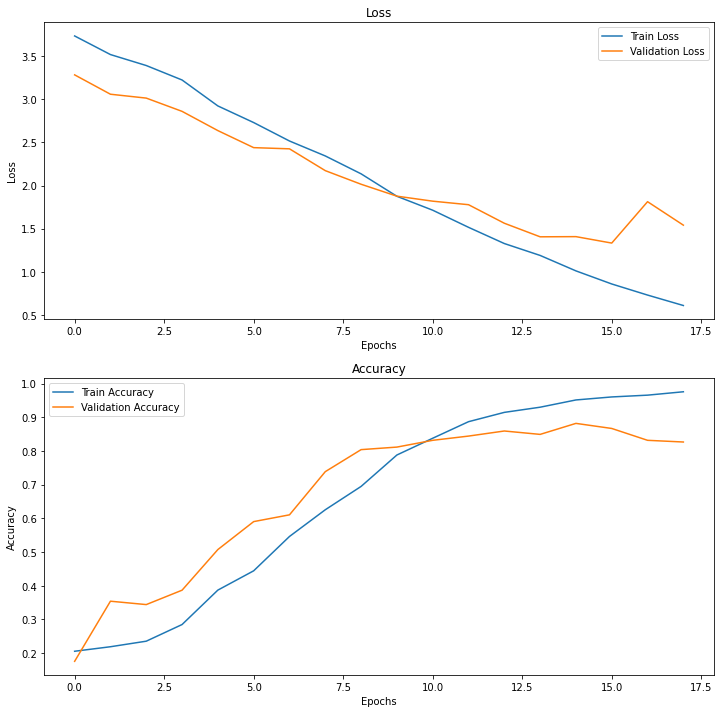

In [229]:
import matplotlib.pyplot as plt

# 정확한 val_loss 및 val_accuracy 플롯
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Train/Val Loss Plot
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Train/Val Accuracy Plot
axs[1].plot(history.history['accuracy'], label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [230]:
model.evaluate(val_dataset)

13/13 [==============================] - 0s 19ms/step - loss: 1.3341 - accuracy: 0.8668


[1.334114909172058, 0.8668341636657715]

# 하이퍼 파라미터 튜닝용

- 이 sweep_config 설정은 W&B (Weights & Biases) Sweep을 통해 모델의 하이퍼파라미터를 무작위로 탐색하여 val_loss를 최소화하는 최적의 조합을 찾기 위한 설정입니다. 

In [ ]:
sweep_config = {
    "name": "sweep_test_nlp",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {

        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            },
        
        "drop_out" : {
            "min": 0.1,
            "max": 0.4
        }
                    
        }
    }

# Submission

In [197]:
import os
import sys
sys.path.append("../")

## 경고 무시
import warnings
warnings.filterwarnings('ignore')

## 시각화 툴
import matplotlib.pyplot as plt
import seaborn as sns

## encoding 
from sklearn.preprocessing import LabelEncoder

## vocabulary
import tensorflow_datasets as tfds

## preprocessor
from custom_preprocessor import Preprocessor

In [198]:
preprocessor = Preprocessor()

In [199]:
preprocessed_train, preprocessed_test = preprocessor.preprocess()

In [200]:
# test 데이터셋 불러와서 text 부분 tokenize 진행
text = preprocessed_test['text']
test_tensor, tokenizer = tokenize(text)

In [201]:
# 크기 확인
test_tensor.shape

(500, 100)

In [231]:
import os
from os.path import join

def save_submission(y_pred, user_name, f1_score=None):
    data_path = "/aiffel/aiffel/dlthon_team5/data"
    save_path = "../submission"
    
    # 기존 submission 불러오기
    submission_path = join(data_path, 'new_submission.csv')
    submission = pd.read_csv(submission_path)
    
    # 예측 클래스 저장
    submission['class'] = y_pred
    
    # F1-Score를 파일명에 반영
    submission_csv_path = '{}/submission_{}_f1score_{:.4f}.csv'.format(save_path, user_name, f1_score)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [232]:
# 뒤쪽 str값은 본인 이니셜과 버전을 작성하면됨
# F1-Score를 포함하여 submission 파일 저장

save_submission(y_pred, 'hsv_v4', 0.8668)

../submission/submission_hsv_v4_f1score_0.8668.csv saved!
